# Applied Machine Learning: In-class Exercise 10-1

## Goal

Learn how to do ensembling and model averaging using `scikit-learn`, and how to optimize ensemble weights manually or with optimization tools.


### Prerequisites

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml

rng = np.random.default_rng(2409)
X, y = fetch_openml(name="credit-g", version=1, as_frame=True, return_X_y=True)

categorical_features = X.select_dtypes(include=["object", "category"]).columns
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)


## 1 Build a “Random Forest” From Scratch

### 1.1 Create Three Bagged Trees

Use a bagging ensemble to combine predictions of decision trees trained on different bootstrap samples of the German Credit data, similarly to how a Random Forest works. Use 3 decision trees, each with a maximum depth of 3.

Train and visualize the resulting ensemble. Also, plot each of the individual decision trees from the ensemble after training on the full dataset.  
Then, train a single decision tree with the same maximum depth on the entire dataset and compare its performance and structure to the ensemble.  

<details><summary>Hint 1:</summary>
Use `BaggingClassifier` with `DecisionTreeClassifier` as the base estimator and set `bootstrap=True` to enable sampling with replacement.
</details>

<details><summary>Hint 2:</summary>
Use `IPython.display.display` and `IPython.display.HTML` and `sklearn.tree.plot_tree` for visualization.
</details>

Bagging Ensemble - 10-fold CV Results:
Individual fold accuracies: [0.71 0.68 0.73 0.77 0.58 0.71 0.71 0.75 0.74 0.71]
Mean accuracy: 0.7090
Standard deviation: 0.0493


Single Decision Tree - 10-fold CV Results:
Individual fold accuracies: [0.74 0.7  0.73 0.75 0.61 0.75 0.69 0.73 0.72 0.67]
Mean accuracy: 0.7090
Standard deviation: 0.0413

Ensemble Structure Visualization:


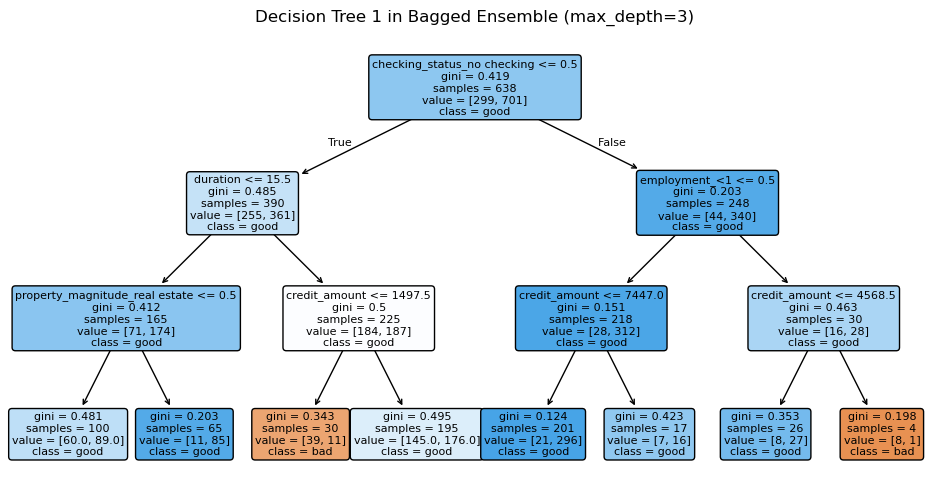

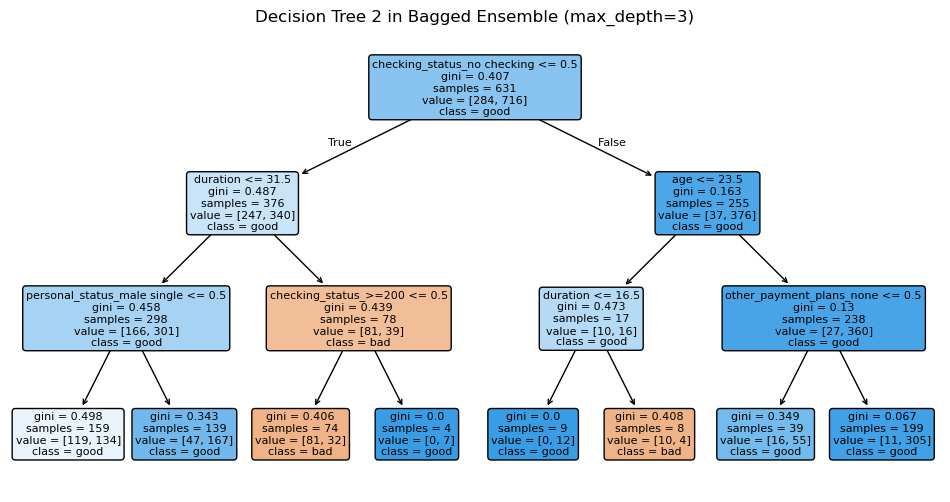

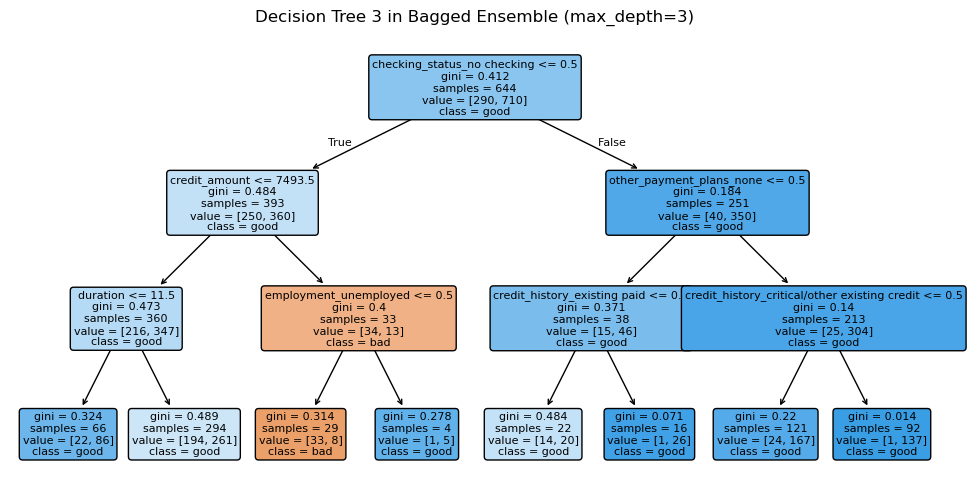

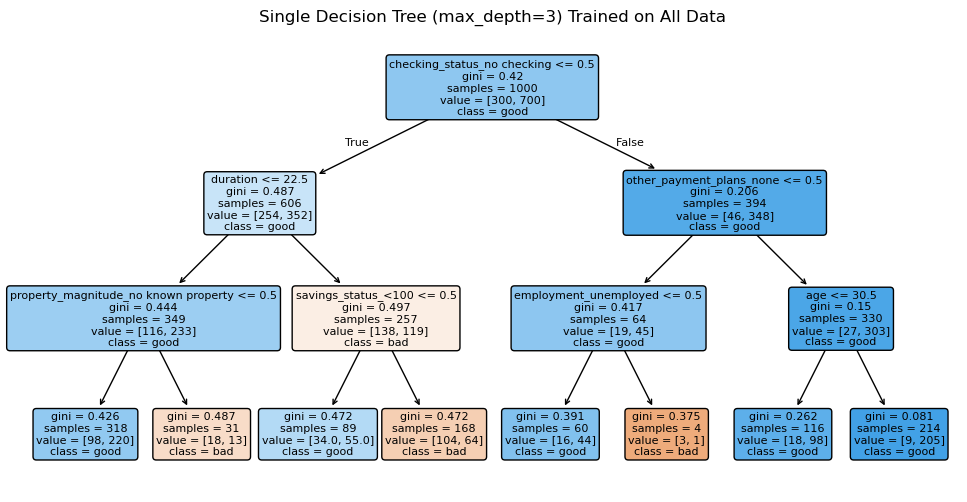

In [2]:
#===SOLUTION===

# Set environment variable for Array API compatibility
import os
os.environ["SCIPY_ARRAY_API"] = "1"

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import estimator_html_repr
from IPython.display import display, HTML
from sklearn.model_selection import cross_val_score, KFold


# Create a bagging ensemble with 3 trees
base_tree = DecisionTreeClassifier(max_depth=3, random_state=2409)
bagging_ensemble = BaggingClassifier(
    estimator=base_tree,
    n_estimators=3,
    bootstrap=True,
    random_state=2409
)

# Create a single decision tree for comparison
single_tree = DecisionTreeClassifier(max_depth=3, random_state=2409)

# Set up 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=2409)

# Perform 10-fold cross-validation for both models
bagging_scores = cross_val_score(bagging_ensemble, X, y, cv=kf, scoring='accuracy')
single_tree_scores = cross_val_score(single_tree, X, y, cv=kf, scoring='accuracy')

print("Bagging Ensemble - 10-fold CV Results:")
print(f"Individual fold accuracies: {bagging_scores}")
print(f"Mean accuracy: {bagging_scores.mean():.4f}")
print(f"Standard deviation: {bagging_scores.std():.4f}")
print("\n")

print("Single Decision Tree - 10-fold CV Results:")
print(f"Individual fold accuracies: {single_tree_scores}")
print(f"Mean accuracy: {single_tree_scores.mean():.4f}")
print(f"Standard deviation: {single_tree_scores.std():.4f}")

# Train the models on the full dataset for visualization
bagging_ensemble.fit(X, y)
single_tree.fit(X, y)

# Visualize the ensemble structure
print("\nEnsemble Structure Visualization:")
html_repr = estimator_html_repr(bagging_ensemble)
display(HTML(html_repr))

# Plot each of the 3 decision trees in the ensemble
for i, tree in enumerate(bagging_ensemble.estimators_):
    plt.figure(figsize=(12, 6))
    plot_tree(
        tree,
        feature_names=X.columns,
        class_names=["bad", "good"],
        filled=True,
        rounded=True,
        fontsize=8
    )
    plt.title(f"Decision Tree {i+1} in Bagged Ensemble (max_depth=3)")
    plt.show()

plt.figure(figsize=(12, 6))
plot_tree(
    single_tree,
    feature_names=X.columns,
    class_names=["bad", "good"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Single Decision Tree (max_depth=3) Trained on All Data")
plt.show()


Discuss: What is still missing to fully replicate the behavior of a Random Forest?


===SOLUTION===

Although each of the 3 trees sees different data during training, the first split is the same as if we had trained on all data. In an actual Random Forest, feature variables are randomly selected as potential splitting candidates which makes trees more heterogeneous.

### 1.2 Reset Maximum Depth and Compare to Random Forest

Reset the `max_depth` hyperparameter for both the ensemble and the single decision tree, allowing them to grow without depth constraints. Then benchmark the ensemble of three bagged trees against the single decision tree, as well as against actual Random Forest classifiers with 3, 10, and 100 trees.

Use 10-fold cross-validation to evaluate and compare models based on their ROC AUC scores.

As a follow-up question: Would it make sense to adjust the contribution of individual models when averaging their predictions?

<details><summary>Hint 1:</summary>
In `scikit-learn`, set `max_depth=None` in `DecisionTreeClassifier` to allow trees to grow fully.
</details>

<details><summary>Hint 2:</summary>
Use `RandomForestClassifier` with varying `n_estimators` values to simulate Random Forests of different sizes.
</details>

Bagged Ensemble (3 trees): Mean ROC AUC = 0.6820 (Std = 0.0403)
Single Decision Tree: Mean ROC AUC = 0.6333 (Std = 0.0470)
Random Forest (3 trees): Mean ROC AUC = 0.6919 (Std = 0.0477)
Random Forest (10 trees): Mean ROC AUC = 0.7528 (Std = 0.0461)
Random Forest (100 trees): Mean ROC AUC = 0.7898 (Std = 0.0399)


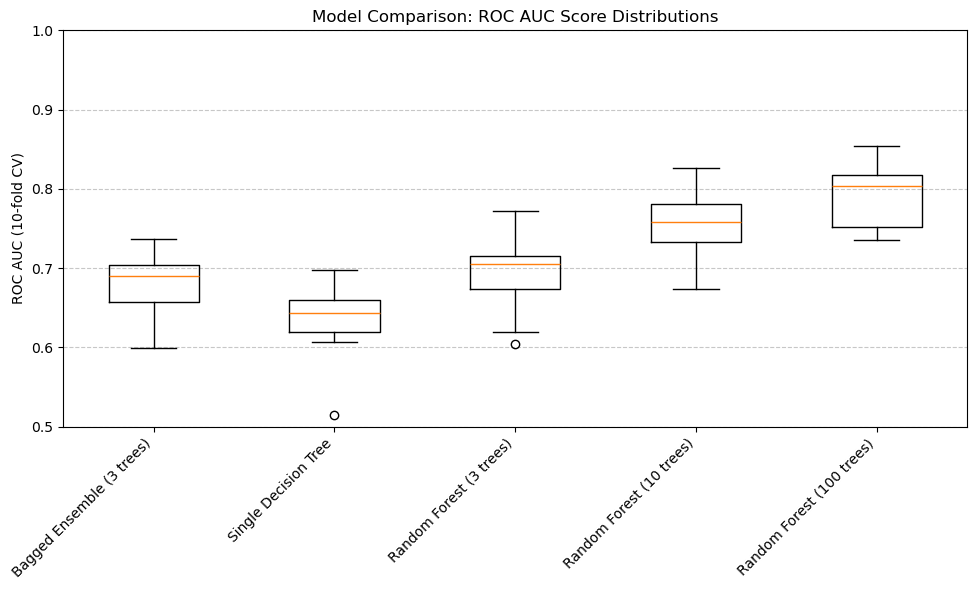

In [3]:
#===SOLUTION===

from sklearn.ensemble import RandomForestClassifier


# Reset maximum depth for each tree by setting max_depth=None
# Bagged Ensemble: 3 bagged trees with no depth constraint
bagging_ensemble = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None, random_state=2409),
    n_estimators=3,
    bootstrap=True,
    random_state=2409
)

single_tree = DecisionTreeClassifier(max_depth=None, random_state=2409)

rf3 = RandomForestClassifier(n_estimators=3, random_state=2409)
rf10 = RandomForestClassifier(n_estimators=10, random_state=2409)
rf100 = RandomForestClassifier(n_estimators=100, random_state=2409)

# Create a dictionary of models for benchmarking
models = {
    "Bagged Ensemble (3 trees)": bagging_ensemble,
    "Single Decision Tree": single_tree,
    "Random Forest (3 trees)": rf3,
    "Random Forest (10 trees)": rf10,
    "Random Forest (100 trees)": rf100
}
names = list(models.keys())

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring="roc_auc")
    results[name] = scores
    print(f"{name}: Mean ROC AUC = {scores.mean():.4f} (Std = {scores.std():.4f})")

plt.figure(figsize=(10, 6))
plt.boxplot([results[name] for name in names], labels=names)
plt.ylabel("ROC AUC (10-fold CV)")
plt.title("Model Comparison: ROC AUC Score Distributions")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Question: what is your observation?

===SOLUTION===

Ensemble of 3 trees maybe slightly better than a single tree. Real random forests with many trees much better. If you have the time, maybe set the number of our tree ensemble higher and see how that compares.

## 2 Model Averaging

Use a soft voting ensemble to combine the predictions of a decision tree, a k-NN classifier (with *k = 7*), and a logistic regression model. Benchmark this ensemble against each individual learner as well as a featureless baseline. Use 10-fold cross-validation to evaluate the models using ROC AUC.

By default, the voting ensemble assigns equal weights to each model.  
Can you manually find a weighting scheme that leads to better ROC AUC performance than equal weights?

<details><summary>Hint 1:</summary>
Use `VotingClassifier` with `voting='soft'` to average predicted probabilities.
</details>

<details><summary>Hint 2:</summary>
Try setting different `weights=[...]` in the `VotingClassifier` and compare the results.
</details>

In [4]:
#===SOLUTION===

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

random_state = 2409

# Create pipelines with StandardScaler for logistic regression that benefit from scaling
dt = DecisionTreeClassifier(max_depth=5, random_state=random_state)
knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7))
])
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=1000, penalty='l2', random_state=random_state))
])

dummy = DummyClassifier(strategy="most_frequent", random_state=random_state)


# Equal weights ensemble (default: equal contribution from each model)
ensemble_equal = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('log_reg', log_reg)],
    voting='soft',
    weights=[1, 1, 1]
)

# Adjusted weights ensemble: assign 0.3 to the decision tree, 0.1 to k-NN, and 0.6 to logistic regression.
ensemble_adjusted = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('log_reg', log_reg)],
    voting='soft',
    weights=[0.3, 0.1, 0.6]
)

models = {
    "Ensemble Equal Weights": ensemble_equal,
    "Ensemble Adjusted Weights": ensemble_adjusted,
    "Decision Tree": dt,
    "k-NN (k=7)": knn,
    "Logistic Regression": log_reg,
    "Featureless (Dummy)": dummy
}

results = {}
print("10-fold CV ROC AUC scores:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=10, scoring="roc_auc")
    results[name] = {
        'Mean ROC AUC': scores.mean(),
        'Std': scores.std()
    }

results_df = pd.DataFrame(results).T
print("10-fold CV ROC AUC scores:")
print(results_df)

10-fold CV ROC AUC scores:
10-fold CV ROC AUC scores:
                           Mean ROC AUC       Std
Ensemble Equal Weights         0.785333  0.053100
Ensemble Adjusted Weights      0.793952  0.046949
Decision Tree                  0.703476  0.042103
k-NN (k=7)                     0.723667  0.060193
Logistic Regression            0.788333  0.049139
Featureless (Dummy)            0.500000  0.000000


## 3 Optimizing Weights

Building on the previous model averaging exercise, we now aim to optimize the ensemble weights numerically. In this case, we perform a simple random search to find the best weighting scheme for the three models: decision tree, k-NN (k = 7), and logistic regression.

We define an **objective function** that:

- Accepts a candidate vector of weights
- Normalizes them so they sum to 1
- Applies them in a soft voting ensemble
- Evaluates the ensemble using 10-fold cross-validation with ROC AUC as the metric
- Returns the mean ROC AUC

Even though this is a constrained optimization problem (weights should sum to 1), we simply sample weights freely from the range [0, 1] and normalize them inside the objective. Thus, we are effectively reducing the problem to two degrees of freedom.

We then evaluate a small number of evaluations and report the best-performing weight configuration.

In [5]:
#===SOLUTION===

from sklearn.base import clone
from typing import Union, Tuple

# Define base models
dt = clone(models["Decision Tree"])
knn = clone(models["k-NN (k=7)"])
log_reg = clone(models["Logistic Regression"])


def objective_function(xs: Union[list[float], np.ndarray]) -> Tuple[float, np.ndarray]:
    """
    Objective function that evaluates a weighted ensemble using 10-fold CV.

    Args:
        xs (Union[list[float], np.ndarray]): Three weights [w_dt, w_knn, w_log_reg].

    Returns:
        Tuple: 
            - mean_score (float): Mean ROC AUC from 10-fold cross-validation.
            - norm_weights (np.ndarray): Normalized weights that sum to 1.
    """
    # Normalize weights to sum to 1
    weights = np.array(xs)
    weights = weights / weights.sum()
    
    # Create the ensemble with these weights using soft voting
    ensemble = VotingClassifier(
        estimators=[('dt', dt), ('knn', knn), ('log_reg', log_reg)],
        voting='soft',
        weights=weights.tolist()
    )
    
    # Evaluate the ensemble using 10-fold cross-validation with ROC AUC
    scores = cross_val_score(ensemble, X, y, cv=10, scoring="roc_auc")
    return scores.mean(), weights

# Random search: optimize over the three weight parameters with 10 evaluations.
n_evals = 10
best_score = 0
best_weights = None

print("Evaluating candidate weight vectors:")
for i in range(n_evals):
    # Sample three candidate weights uniformly from [0, 1]
    candidate = rng.uniform(0, 1, size=3)
    score, norm_weights = objective_function(candidate)
    
    # Update best score and weights if current score is better
    if score > best_score:
        best_score = score
        best_weights = norm_weights

# Report the best weights and final average AUROC
print("\nBest weights found:")
print(f"Weights: {best_weights}, Best Mean ROC AUC: {best_score:.4f}")
print(f"Decision Tree: {best_weights[0]:.4f}, k-NN: {best_weights[1]:.4f}, Logistic Regression: {best_weights[2]:.4f}")

# Create the best ensemble with the optimized weights
best_ensemble = VotingClassifier(
    estimators=[('dt', dt), ('knn', knn), ('log_reg', log_reg)],
    voting='soft',
    weights=best_weights.tolist()
)

final_scores = cross_val_score(best_ensemble, X, y, cv=10, scoring="roc_auc")
final_mean_score = final_scores.mean()
print(f"\nFinal average ROC AUC of the optimized ensemble: {final_mean_score:.4f}")

Evaluating candidate weight vectors:

Best weights found:
Weights: [0.07084791 0.2864794  0.64267268], Best Mean ROC AUC: 0.7949
Decision Tree: 0.0708, k-NN: 0.2865, Logistic Regression: 0.6427

Final average ROC AUC of the optimized ensemble: 0.7949


Question: why is your approach (i.e., how we constructed the objective function) ineffective?

===SOLUTION===

This approach is inefficient because we use resampling in the objective function. There is no need to always retrain and evaluate the learners because we only weight predictions differently and average them.

## 4 Optimizing Weights Efficiently

In the previous exercise, we used a naive approach to optimize ensemble weights by training models repeatedly during the optimization loop. This is computationally expensive and redundant.

Now, we improve efficiency by **precomputing the cross-validated predictions** for each model and rewriting the objective function to operate directly on these stored predictions. This lets us evaluate different weighting schemes *without retraining the models*.

Then, we use **CMA-ES** (Covariance Matrix Adaptation Evolution Strategy) as the optimizer, limiting the process to 100 function evaluations.

### Workflow:

- Perform 10-fold cross-validation and store the predicted probabilities of each base learner (decision tree, k-NN, logistic regression) for each fold.
- Construct an objective function that:
  - Takes a candidate weight vector
  - Normalizes it
  - Combines the precomputed predictions accordingly
  - Computes the mean ROC AUC across folds
- Use the package `cma` and `cma.fmin()` to find the optimal weights.

This setup allows us to evaluate many weight combinations quickly and is far more efficient than retraining the ensemble on each iteration.

<details><summary>Hint 1:</summary>
Store predictions before optimization, and use weighted combinations of those to evaluate ROC AUC.
</details>

<details><summary>Hint 2:</summary>
Use `cma.fmin()` to optimize a function that returns the **negative** ROC AUC, since CMA-ES minimizes by default.
</details>

In [6]:
import shutil
import os
import cma
from sklearn.metrics import roc_auc_score


n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# We'll store predictions from each fold in a list of dictionaries.
folds = []

for train_index, test_index in kf.split(X):
    fold_data = {}
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Decision Tree predictions
    dt_model = clone(dt)
    dt_model.fit(X_train, y_train)
    dt_prob = dt_model.predict_proba(X_test)[:, 1]
    
    # k-NN predictions
    knn_model = clone(knn)
    knn_model.fit(X_train, y_train)
    knn_prob = knn_model.predict_proba(X_test)[:, 1]
    
    # Logistic Regression predictions
    log_reg_model = clone(log_reg)
    log_reg_model.fit(X_train, y_train)
    log_reg_prob = log_reg_model.predict_proba(X_test)[:, 1]
    
    fold_data['y_true'] = y_test.values
    fold_data['dt_prob'] = dt_prob
    fold_data['knn_prob'] = knn_prob
    fold_data['log_reg_prob'] = log_reg_prob
    folds.append(fold_data)

print(f"Precomputed predictions for {n_splits} folds.")


def efficient_objective(weights):
    """
    Given candidate weights for dt, knn, and log_reg, normalize them, combine the 
    precomputed predictions from each fold, and return the negative mean ROC AUC.
    
    Parameters:
        weights (array-like): Candidate weights [w_dt, w_knn, w_log_reg].
    
    Returns:
        float: Negative mean ROC AUC over all folds.
    """
    # Normalize weights so they sum to 1
    weights = np.array(weights)
    if weights.sum() == 0:
        norm_weights = np.ones_like(weights) / len(weights)
    else:
        norm_weights = weights / weights.sum()
    
    aucs = []
    for fold in folds:
        # Combine the probabilities using the candidate weights
        combined_prob = (norm_weights[0] * fold['dt_prob'] +
                         norm_weights[1] * fold['knn_prob'] +
                         norm_weights[2] * fold['log_reg_prob'])
        auc = roc_auc_score(fold['y_true'], combined_prob)
        aucs.append(auc)
    mean_auc = np.mean(aucs)
    # Return negative because we want to maximize AUC but the optimizer minimizes.
    return -mean_auc

# Optimize the weights using CMA-ES
# Initial guess: equally weighted ensemble
initial_weights = [0.33, 0.33, 0.33]
# Standard deviation for the search (tuning parameter)
sigma = 0.2

res = cma.fmin(efficient_objective, initial_weights, sigma, options={'maxfevals': 100, 'verb_disp': 1})

best_weights = res[0]
# Normalize the best weights
best_weights = np.array(best_weights)
best_weights = best_weights / best_weights.sum()
best_auc = -efficient_objective(best_weights)

print(f"Decision Tree Weight: {best_weights[0]:.4f}")
print(f"k-NN Weight:         {best_weights[1]:.4f}")
print(f"Logistic Reg Weight: {best_weights[2]:.4f}" + "\n" + "=" * 10)
print(f"Best Mean ROC AUC:   {best_auc:.4f}")


# Check if the cache directory exists and delete it
cache_dir = "./outcmaes/"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)


Precomputed predictions for 10 folds.
(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=748448, Mon May 19 12:30:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 -7.944459549287289e-01 1.0e+00 1.94e-01  2e-01  2e-01 0:00.1
    2     14 -7.956705054744518e-01 1.2e+00 1.60e-01  1e-01  2e-01 0:00.1
    3     21 -7.958817825655461e-01 1.5e+00 1.45e-01  1e-01  1e-01 0:00.2
    4     28 -7.973704070093677e-01 1.4e+00 1.67e-01  1e-01  2e-01 0:00.2
    5     35 -7.966840001920674e-01 1.5e+00 1.38e-01  1e-01  1e-01 0:00.3
    6     42 -7.973377718540319e-01 1.6e+00 1.26e-01  9e-02  1e-01 0:00.3
    7     49 -7.971337896491760e-01 1.5e+00 1.11e-01  7e-02  9e-02 0:00.4
    8     56 -7.970965076430577e-01 1.5e+00 9.27e-02  5e-02  7e-02 0:00.4
    9     63 -7.975273977312088e-01 1.7e+00 1.17e-01  6e-02  1e-01 0:00.4
   10     70 -7.986905769479922e-01 2.0e+00 1.19e-01  7e-02  1e-01 0:00.5
Iterat #Fevals   function value  axis ratio  sigma  min&max 

## Summary

We built a bagged ensemble of trees from scratch and compared its performance to a single tree and actual random forests with different numbers of trees. We then performed model averaging of a decision tree, a k-NN and a logistic regression. Choosing weights manually is cumbersome so we optimized them both in a straightforward but inefficient and a slightly more demanding but efficient way.